In [1]:
from MagicCube.cube import Cube
from pyTwistyScrambler import scrambler222
from enum import Enum

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pandas as pd

In [2]:
c = Cube(2)

In [3]:
c.move('F', 0, 1) # 'F'
c.move('R', 0, 1) # 'R'

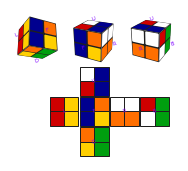

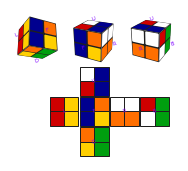

In [4]:
c.render()

In [5]:
c.colordict

{'w': 0, 'y': 1, 'b': 2, 'g': 3, 'o': 4, 'r': 5}

In [6]:
display("Color Dict:", [ (key, value) for (key, value) in sorted( c.colordict.items(), key=lambda x: x[1] )])
display("Face Dict", [ (key, value) for (key, value) in sorted( c.facedict.items(), key=lambda x: x[1] ) ])
display("Sticker State", c.stickers)

'Color Dict:'

[('w', 0), ('y', 1), ('b', 2), ('g', 3), ('o', 4), ('r', 5)]

'Face Dict'

[('U', 0), ('D', 1), ('F', 2), ('B', 3), ('R', 4), ('L', 5)]

'Sticker State'

array([[[5, 0],
        [2, 2]],

       [[1, 4],
        [3, 3]],

       [[2, 2],
        [1, 4]],

       [[0, 5],
        [3, 3]],

       [[4, 0],
        [4, 0]],

       [[5, 5],
        [1, 1]]])

In [7]:
display(c.stickers.shape)
display(c.stickers.reshape(12, 2))

(6, 2, 2)

array([[5, 0],
       [2, 2],
       [1, 4],
       [3, 3],
       [2, 2],
       [1, 4],
       [0, 5],
       [3, 3],
       [4, 0],
       [4, 0],
       [5, 5],
       [1, 1]])

Here we identify all the piece locations on the face dict.

In [8]:
front_left_top =   [ [2, 0, 1], [5, 1, 1], [0, 0, 0] ]
front_right_top =  [ [2, 1, 1], [4, 0, 1], [0, 1, 0] ]
front_left_down =  [ [2, 0, 0], [5, 1, 0], [1, 0, 1] ]
front_right_down = [ [2, 1, 0], [4, 0, 0], [1, 1, 1] ]
back_left_top =    [ [3, 1, 1], [5, 0, 1], [0, 0, 1] ]
back_right_top =   [ [3, 0, 1], [4, 1, 1], [0, 1, 1] ]
back_left_down =   [ [3, 1, 0], [5, 0, 0], [1, 0, 0] ]
back_right_down =  [ [3, 0, 0], [4, 1, 0], [1, 1, 0] ]

all_pieces = [
    front_left_top,
    front_right_top,
    front_left_down,
    front_right_down,
    back_left_top,
    back_right_top,
    back_left_down,
    back_right_down,
]

In [9]:
display("Color Dict:", [ (key, value) for (key, value) in sorted( c.colordict.items(), key=lambda x: x[1] )])

'Color Dict:'

[('w', 0), ('y', 1), ('b', 2), ('g', 3), ('o', 4), ('r', 5)]

In [10]:
class PieceColors(Enum):
    WHITE_BLUE_RED=0
    WHITE_BLUE_ORANGE=1
    WHITE_GREEN_RED=2
    WHITE_GREEN_ORANGE=3
    YELLOW_BLUE_RED=4
    YELLOW_BLUE_ORANGE=5
    YELLOW_GREEN_RED=6
    YELLOW_GREEN_ORANGE=7

piece_color_mapping = {
    (0, 2, 5): PieceColors.WHITE_BLUE_RED,
    (0, 2, 4): PieceColors.WHITE_BLUE_ORANGE,
    (0, 3, 5): PieceColors.WHITE_GREEN_RED,
    (0, 3, 4): PieceColors.WHITE_GREEN_ORANGE,
    (1, 2, 5): PieceColors.YELLOW_BLUE_RED,
    (1, 2, 4): PieceColors.YELLOW_BLUE_ORANGE,
    (1, 3, 5): PieceColors.YELLOW_GREEN_RED,
    (1, 3, 4): PieceColors.YELLOW_GREEN_ORANGE
}
    
def get_scramble(n=2):
    if n == 2:
        return scrambler222.get_optimal_scramble().split(' ')
    raise ValueError("Unsupported cube size")

    
def get_block_colors(colors):
    colors = tuple(sorted(list(colors)))
    return piece_color_mapping[colors]

In [14]:
num_classes = 9
one_hot = np.identity(9)
possible_moves = ['F', "F'", 'F2', 'R', "R'", 'R2', 'U', "U'", 'U2']
move_mapping = dict(
    [(move, i) for i, move in enumerate(
        possible_moves
    )]
)
move_mapping

{'F': 0, "F'": 1, 'F2': 2, 'R': 3, "R'": 4, 'R2': 5, 'U': 6, "U'": 7, 'U2': 8}

In [15]:
def convert_move(m):
    return {
        "F" : ('F', 0, 1),
        "F'" : ('F', 0, -1),
        "F2": ('F', 0, 2),
        "B" : ('B', 0, 1),
        "B'": ('B', 0, -1),
        "B2": ('B', 0, 2),
        "L": ('L', 0, 1),
        "L'": ('L', 0, -1),
        "L2": ('L', 0, 2),
        "R": ('R', 0, 1),
        "R'": ('R', 0, -1),
        "R2": ('R', 0, 2),
        "U": ('U', 0, 1),
        "U'": ('U', 0, -1),
        "U2": ('U', 0, 2),
        "D": ('D', 0, 1),
        "D'": ('D', 0, -1),
        "D2": ('D', 0, 2),
    }[m]

def counter_move(m):
    return {
        "F": "F'",
        "F'": "F",
        "B'": "B'",
        "B": "B",
        "R": "R'",
        "R'": "R",
        "L": "L'",
        "L'": "L",
        "U": "U'",
        "U'": "U",
        "D": "D'",
        "D'": "D",
        "F2": "F2",
        "B2": "B2",
        "R2": "R2",
        "L2": "L2",
        "U2": "U2",
        "D2": "D2",
    }[m]
    
def generate_case(moves=10):
    if moves > 10:
        raise ValueError("Only up to 10 moves supported")
    scramble = get_scramble()[0:moves]
    undo_scramble = [counter_move(m) for m in reversed(scramble)]
    return scramble, undo_scramble

def unfold_case(scramble, undo_scramble):
    c = Cube(2)
    n = len(scramble)
    X_stickers = np.zeros( (n, 12, 2, 1) )
    X_pieces = np.zeros((n, 8))
    y = np.zeros(n)
    for i in range(n):
        c.move(*convert_move(scramble[i]))
        solution = undo_scramble[i]
        stickers = c.stickers.copy()
        state = np.asarray(stickers).reshape(12, 2, 1)
        X_stickers[i] = state
        for j, piece in enumerate(all_pieces):
            piece_stickers = []
            for sticker_pos in piece:
                sticker_color = stickers[
                    sticker_pos[0], sticker_pos[1], sticker_pos[2]
                ]
                piece_stickers.append(sticker_color)
            X_pieces[i][j] = get_block_colors(piece_stickers).value
        y[i] = move_mapping[solution]
    return X_stickers, X_pieces, y


def data_generator(solves=5000):
    stickers = []
    pieces = []
    solutions = []
    for i in range(solves):
        if i % 100 == 0:
            print(f'{i}/{solves} completed')
        scramble, reverse = generate_case(moves=10)
        s, p, y = unfold_case(scramble, reverse)
        stickers.append(s)
        pieces.append(p)
        solutions.append(y)
    stickers = np.concatenate(stickers, axis=0)
    pieces = np.concatenate(pieces, axis=0)
    solutions = np.concatenate(solutions, axis=0)
    return stickers, pieces, solutions


In [16]:
stickers, pieces, solutions = data_generator(solves=100)

0/100 completed


In [18]:
SAVE_STICKERS = "data/train_stickers_doubles.npy"
SAVE_PIECES = "data/train_pieces_doubles.npy"
SAVE_SOLUTIONS = "data/train_solutions_doubles.npy"

In [19]:
np.save(SAVE_STICKERS, stickers)
np.save(SAVE_PIECES, pieces)
np.save(SAVE_SOLUTIONS, solutions)

# Create training and validation sets

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
# Attempting to add piece information to the dataset as well
class CubeDataset(Dataset):
    def __init__(self, stickers, solutions):
        self.y = solutions.astype(np.int64)
        self.stickers = stickers.swapaxes(1, 3).astype(np.float64)
        self.n = stickers.shape[0]
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        return (self.stickers[idx], self.y[idx])


In [22]:
def unison_shuffle(*data):
    assert all(
        [len(data[i]) == len(data[i+1]) for i in range(len(data) - 1)]
    )
    size = len(data[0])
    p = np.random.permutation(size)
    return tuple([d[p] for d in data])

In [23]:
train_stickers = np.load(SAVE_STICKERS)
train_pieces = np.load(SAVE_PIECES)
train_solutions = np.load(SAVE_SOLUTIONS)

In [25]:
train_stickers.shape, train_pieces.shape, train_solutions.shape

((891, 12, 2, 1), (891, 8), (891,))

In [26]:
size_dataset = len(train_solutions)

size_validation = int(size_dataset * .2)

In [27]:
train_stickers_X = train_stickers[:size_dataset-size_validation]
train_pieces_X = train_pieces[:size_dataset-size_validation]
train_y = train_solutions[:size_dataset-size_validation]

validation_stickers_X = train_stickers[-size_validation:]
validation_pieces_X = train_pieces[-size_validation:]
validation_y = train_solutions[-size_validation:]

In [28]:
display(train_stickers_X.shape, train_pieces_X.shape, train_y.shape)
display(validation_stickers_X.shape, validation_pieces_X.shape, validation_y.shape)

(713, 12, 2, 1)

(713, 8)

(713,)

(178, 12, 2, 1)

(178, 8)

(178,)

In [56]:
train_dataset = CubeDataset(train_stickers_X, train_y)
val_dataset = CubeDataset(validation_stickers_X, validation_y)

# Creating a Deep Learning architecture

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

In [58]:
batchsize = 128

train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True)
val_dataloader = DataLoader(val_dataset, batchsize, shuffle=True)

In [59]:
num_classes = 9

In [60]:
class CubeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=128,
            kernel_size=2, stride=1, padding=1
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=128, out_channels=256,
            kernel_size=2, stride=1, padding=1
        )
        
        self.lin1 = nn.Linear(768, 100)
        self.dropout1 = nn.Dropout(.05)
        self.batchnorm1 = nn.BatchNorm1d(100)
        nn.init.kaiming_normal_(self.lin1.weight.data)
        
        self.output = nn.Linear(100, num_classes)
        nn.init.kaiming_normal_(self.output.weight.data)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = F.relu(F.max_pool2d(F.relu(self.conv2(x)), (2, 2)))
        
        x = x.view(-1, 768)
        
        x = F.relu(self.lin1(x))
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        
        x = self.output(x)
        return x

# Perform a grid search for hyperparameters

In [66]:
from livelossplot import PlotLosses

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
print("Using device: " + str(device))

Using device: cuda


In [68]:
def train_model(model, criterion, optimizer, num_epochs=10, should_plot=True, config={}):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.float().to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        if should_plot:
            liveloss.update(logs)
            liveloss.draw()
        if config:    
            print("Current config: ")
            pprint(config)
    return liveloss.metrics_extrema['val_log loss']['min'], \
        liveloss.metrics_extrema['val_accuracy']['max']

In [69]:
dataloaders = {
    'train': val_dataloader,
    'validation': train_dataloader,
}

model = CubeNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

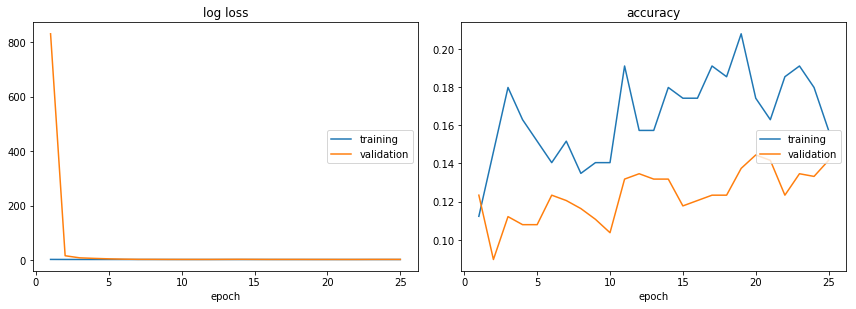

log loss:
training   (min:    2.128, max:    2.476, cur:    2.146)
validation (min:    2.285, max:  830.627, cur:    2.438)

accuracy:
training   (min:    0.112, max:    0.208, cur:    0.157)
validation (min:    0.090, max:    0.144, cur:    0.142)


In [ ]:
train_model(model, criterion, optimizer, num_epochs=500)

# Experimental: Attempting to add embeddings for pieces

In the above attempt, we're simply feeding the neural net a matrix of stickers. In reality, the cube is a collection of pieces. In this attempt, we encode pieces as a type of categorical variable that passes through a 3-dimensional embedding.

In [50]:
num_classes=9

# Attempting to add piece information to the dataset as well
class ExperimentalCubeDataset(Dataset):
    def __init__(self, stickers, pieces, solutions):
        self.y = solutions.astype(np.int64)
        self.stickers = stickers.swapaxes(1, 3).astype(np.float64)
        self.pieces = self._build_pieces(pieces)
        self.n = stickers.shape[0]
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        return (self.stickers[idx], self.pieces[idx], self.y[idx])
    
    def _build_pieces(self, pieces):
        #TODO: vectorize this
        num_pieces = 8
        output = np.zeros( pieces.shape, dtype=int)
        for i, example in enumerate(pieces):
            new_example = np.zeros( num_pieces, dtype=int )
            for cubit_position, encoded_color in enumerate(example):
                # encoded color ranges from [0, 7]
                new_example[int(encoded_color)] = cubit_position
            output[i] = new_example
        return output


In [51]:
experimental_train_dataset = ExperimentalCubeDataset(train_stickers_X, train_pieces_X, train_y)
experimental_val_dataset = ExperimentalCubeDataset(validation_stickers_X, validation_pieces_X, validation_y)

In [52]:
class ExperimentalCubeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=128,
            kernel_size=2, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=128, out_channels=256,
            kernel_size=2, stride=1, padding=1
        )
        
        # 8 pieces encoded into 3 dimensions
        self.embedding = nn.Embedding(8, 3)
        self.emb_lin = nn.Linear(24, 64)
        self.emb_drops = nn.Dropout(.1)
        self.emb_bn = nn.BatchNorm1d(64)
        nn.init.kaiming_normal_(self.emb_lin.weight.data)
        
        
        # Flattened conv dimensionality: 512
        # Flattened embedding dimensionality: 64
        self.lin1 = nn.Linear(576, 60)
        self.dropout1 = nn.Dropout(.1)
        self.batchnorm1 = nn.BatchNorm1d(60)
        nn.init.kaiming_normal_(self.lin1.weight.data)
        
        self.lin2 = nn.Linear(60, 30)
        self.dropout2 = nn.Dropout(.1)
        self.batchnorm2 = nn.BatchNorm1d(30)
        nn.init.kaiming_normal_(self.lin2.weight.data)
        
        
        self.output = nn.Linear(30, num_classes)
        nn.init.kaiming_normal_(self.output.weight.data)
    
    def forward(self, stickers, pieces):
        stickers = F.relu(F.max_pool2d(F.relu(self.conv1(stickers)), (2, 2)))
        stickers = F.relu(F.max_pool2d(F.relu(self.conv2(stickers)), (3, 3)))
        stickers = stickers.view(-1, 256 * 1 * 2)
        
        # dimensions: batch_sz * 8 * 3
        pieces = self.embedding(pieces)
        pieces = pieces.view(-1, 8 * 3)
        pieces = F.relu(self.emb_lin(pieces))
        pieces = self.emb_drops(pieces)
        pieces = self.emb_bn(pieces)
        
        x = torch.cat( (stickers, pieces), 1)
        
        x = F.relu(self.lin1(x))
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        
        x = F.relu(self.lin2(x))
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        
        x = self.output(x)
        return x

In [53]:
def train_model(model, criterion, optimizer, num_epochs=10, should_plot=True, config={}):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for stickers, pieces, labels in dataloaders[phase]:
                stickers = stickers.float().to(device)
                pieces = pieces.to(device)
                labels = labels.to(device)

                outputs = model(stickers, pieces)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * labels.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        if should_plot:
            liveloss.update(logs)
            liveloss.draw()
        if config:    
            print("Current config: ")
            pprint(config)
    return liveloss.metrics_extrema['val_log loss']['min'], \
        liveloss.metrics_extrema['val_accuracy']['max']

In [54]:
batchsize = 128

experimental_train_dataloader = DataLoader(experimental_train_dataset, batchsize, shuffle=True)
experimental_val_dataloader = DataLoader(experimental_val_dataset, batchsize, shuffle=True)

dataloaders = {
    'train': experimental_train_dataloader,
    'validation': experimental_val_dataloader,
}

model = ExperimentalCubeNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.2)

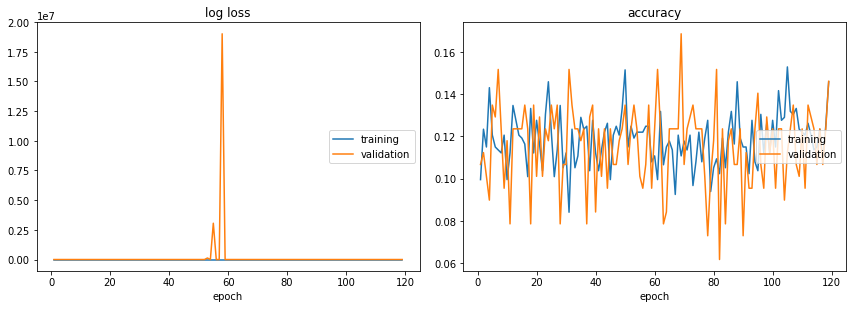

log loss:
training   (min:    2.188, max:    2.379, cur:    2.247)
validation (min:    2.181, max: 19018786.000, cur:    2.497)

accuracy:
training   (min:    0.084, max:    0.153, cur:    0.146)
validation (min:    0.062, max:    0.169, cur:    0.146)


KeyboardInterrupt: 

In [55]:
train_model(model, criterion, optimizer, num_epochs =500)